In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np                  
import matplotlib.pyplot as plt                    # plots
import seaborn as sns                              # more plots
from dateutil.relativedelta import relativedelta   # working with dates with style
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from math import sqrt
from sklearn.metrics import mean_squared_error
from math import sqrt
import statistics
from numpy import array
print(__doc__)
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
np.random.seed(1)

Automatically created module for IPython interactive environment


In [2]:
data = pd.read_excel(r'C:\Users\u22v09\Desktop\Billing Data 2016 to July 2020.xlsx',skiprows=3)

In [3]:
data

,Customer Segment,Month,2016,2017,2018,2019,2020,Grand Total
0,DIR,Jan,80.867485,77.740950,104.021080,41.170140,306.175585,609.975240
1,NaN,Feb,173.982527,79.404745,165.949030,95.725120,219.884278,734.945700
2,NaN,March,159.529362,207.481385,131.805930,117.128542,111.507920,727.453139
3,NaN,April,96.101656,129.967310,103.114630,132.594930,0.000000,461.778526
4,NaN,May,105.910721,114.721740,132.691260,133.538310,93.440367,580.302398
...,...,...,...,...,...,...,...,...
56,NaN,Sep,53.417010,58.696649,56.496137,65.652423,NaN,234.262219
57,NaN,Oct,52.051859,58.591214,79.972150,61.446451,NaN,252.061675
58,NaN,Nov,39.181285,81.330690,54.775610,97.236324,NaN,272.523909
59,NaN,Dec,68.341527,80.893484,65.909737,69.605557,NaN,284.750305


In [4]:
# data[['Customer Segment']].bfill(axis = 0) 
data['Customer Segment ']= data['Customer Segment '].fillna(method = "ffill")

In [5]:
data=data[data['Customer Segment ']== 'DIR']

In [6]:
data.drop('Grand Total', axis = 1, inplace = True)
data=pd.melt(data, id_vars =['Month','Customer Segment '])
data=data.dropna()

In [7]:
df=data.copy()
df['Date'] =pd.to_datetime(df.variable.astype(str) + '/' + df.Month.astype(str) + '/01')
df.head()

,Month,Customer Segment,variable,value,Date
0,Jan,DIR,2016,80.867485,2016-01-01
1,Feb,DIR,2016,173.982527,2016-02-01
2,March,DIR,2016,159.529362,2016-03-01
3,April,DIR,2016,96.101656,2016-04-01
4,May,DIR,2016,105.910721,2016-05-01


In [8]:
df = df.sort_values('Date')
df = df.set_index('Date')

In [9]:
df.head()

,Month,Customer Segment,variable,value
Date,,,,
2016-01-01,Jan,DIR,2016,80.867485
2016-02-01,Feb,DIR,2016,173.982527
2016-03-01,March,DIR,2016,159.529362
2016-04-01,April,DIR,2016,96.101656
2016-05-01,May,DIR,2016,105.910721


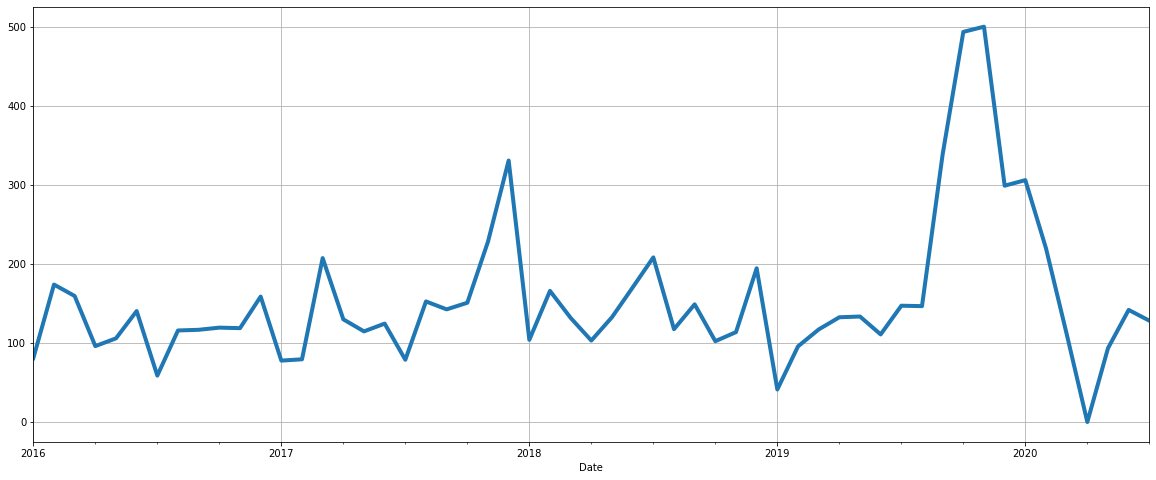

In [10]:
df=df.rename(columns={'value':'ASP'})
df['ASP'].plot(figsize = (20,8), lw = 4, grid = True)

In [11]:
df = df[['ASP']]

In [12]:
df.head()

,ASP
Date,
2016-01-01,80.867485
2016-02-01,173.982527
2016-03-01,159.529362
2016-04-01,96.101656
2016-05-01,105.910721


In [13]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

raw_seq = list(df['ASP'].values)
# raw_seq = list(df)
n_steps = 1
X, y = split_sequence(raw_seq, n_steps = n_steps)
t =[]
x =[]
for i in range(len(X)):
    t.append(X[i])
    x.append(y[i])
inp = pd.DataFrame(t)
inp = inp.rename(columns= {0:'in'})
out = pd.DataFrame(x)
out = out.rename(columns= {0:'out'})
df = inp.merge(out, left_index = True, right_index = True)

In [14]:
df.head()

,in,out
0,80.867485,173.982527
1,173.982527,159.529362
2,159.529362,96.101656
3,96.101656,105.910721
4,105.910721,140.438678


# Test - Train Split

In [15]:
X = np.atleast_2d(df['in'].values).T
len(X)

54

In [16]:
y = df['out'].ravel()
len(y)

54

In [17]:
train_X = X[:46]
train_y = y[:46]
test_X = X[45:]
test_y = y[45:]

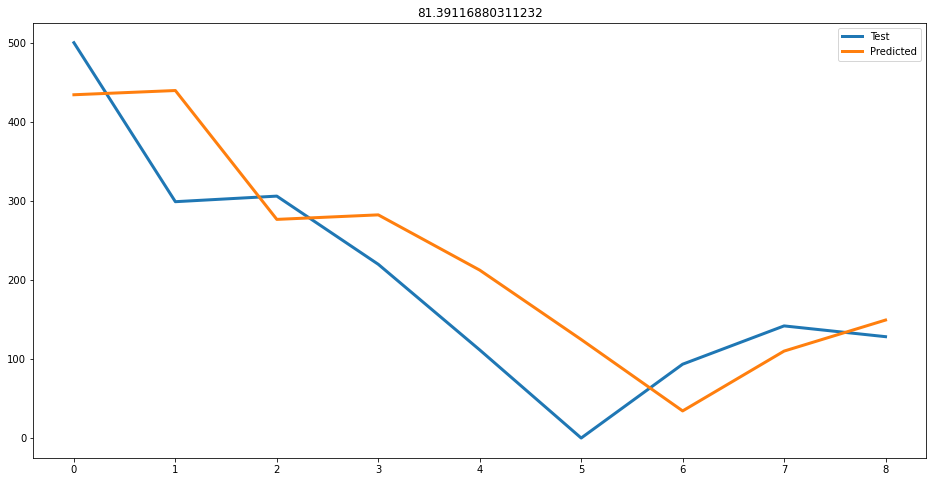

In [18]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=0).fit(train_X, train_y)
pred, sigma = gp.predict(test_X, return_std=True)
rms = sqrt(mean_squared_error(test_y, pred))
out = pd.DataFrame(train_y).append(pd.DataFrame(test_y)).reset_index()

plt.figure(figsize=(16,8))
# plt.plot(train_y, label = "Training")
plt.plot(test_y, label='Test', lw = 3)
plt.plot(pred, label='Predicted', lw = 3)
plt.legend(loc='best')
plt.title(rms)
plt.show()

In [19]:
# from sklearn.gaussian_process import GaussianProcessRegressor as GPR
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# lbound = 1e-2
# rbound = 1e1
# n_restarts = 50
# n_features = 1 # Actually determined elsewhere in the code
# kernel = C(1.0, (lbound,rbound)) * RBF(n_features*[10], (lbound,rbound))
# gp = GPR(kernel=kernel, n_restarts_optimizer=n_restarts).fit(train_X, train_y)
# test_model, sigma2_pred = gp.predict(test_X, return_std=True)

In [20]:
# test_model

In [21]:
# kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
#     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GPR(kernel=kernel, alpha = 0.0).fit(train_X, train_y)
# test_model, sigma2_pred = gp.predict(test_X, return_std=True)
# test_model

In [22]:
# kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#     + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
# gp = GPR(kernel=kernel, alpha = 0.0).fit(train_X, train_y)
# test_model, sigma2_pred = gp.predict(test_X, return_std=True)
# test_model

In [23]:
# kernel = 1.0 * RBF(length_scale=5000.0, length_scale_bounds=(1e-2, 1e3)) \
#     + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
# gp = GPR(kernel=kernel, alpha = 0.0).fit(train_X, train_y)
# test_model, sigma2_pred = gp.predict(test_X, return_std=True)
# test_model

In [24]:
# plt.figure()
# plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
# plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
# plt.plot(x, y_pred, 'b-', label='Prediction')
# plt.fill(np.concatenate([x, x[::-1]]),
#          np.concatenate([y_pred - 1.9600 * sigma,
#                         (y_pred + 1.9600 * sigma)[::-1]]),
#          alpha=.5, fc='b', ec='None', label='95% confidence interval')
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')
# plt.ylim(-10, 20)
# plt.legend(loc='upper left')

# plt.show()